# View coadds generated by `ImageSampler`

This notebook is for getting a sense of what simulated images look like, and as a first checkpoint for testing the behavior of new artifacts.

## Imports

In [1]:
# for reloading changes made in break_coadd_sbi
%load_ext autoreload
%autoreload 2

# setup torch for use with a CPU
# since this notebook is not intended for training a model
import os
os.environ['CUDA_VISIBLE_DEVICES']=""

import torch
torch.set_num_threads(8)

# typical data analysis imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle

matplotlib.rcParams['figure.dpi']=(150) # for consistent figures

# local imports
from break_coadd_sbi import catsampler
from break_coadd_sbi import imagesampler

## Default Coadds

Simulate star catalogs using `catsampler`, then model coadds with all default values in `imagesampler`. I'm starting with very basic models to get a sense of the modeling workflow.

In [2]:
# define the model for the star catalog
prior_catalog = catsampler.TwoStarCatalogSimulator(
    center = (20.0,40.0),
)

# define the model for the coadd simulation
default_image_model = imagesampler.ImageSampler(
    coadd_depth=5,
    height = 40,
    width = 80,
    translation_artifacts=False,
)

In [3]:
# use a random generator to pull realizations of the models defined above
rng=torch.Generator(device='cpu')

In [23]:
# pull a batch_size number of realizations for a 2 star catalog and resulting coadd

batch_size=1

cat=prior_catalog.sample_catalogs(batch_size,rng)
imgs=default_image_model.sample_images(cat,rng).cpu().numpy()

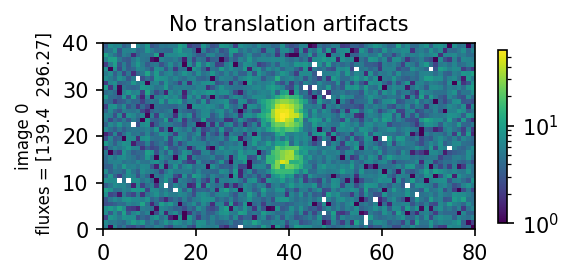

In [24]:
# simple plot for sanity
plt.gcf().set_size_inches(4,3)
plt.pcolormesh(imgs[0],norm='log',vmin=1)
plt.ylabel(f"image {0}\n fluxes = {cat.source_fluxes[0].cpu().numpy().round(2)}", fontsize=8)
plt.colorbar(shrink=0.5)
plt.title(f"No translation artifacts", fontsize=10)
plt.gca().set_aspect('equal')
plt.show()